In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt

import matplotlib.pyplot as figure
import seaborn as sns  

import umap
import tldextract
from sklearn.preprocessing import StandardScaler
import pandas as pd
import publicsuffixlist as psl
import os
from tqdm import tqdm_notebook
from sklearn import preprocessing

In [3]:
another_data_part = pd.read_parquet("data_20180705.parquet", engine= "fastparquet")

In [4]:
another_data_part['pd_ts'] = pd.to_datetime(another_data_part.timestamp, unit='s') 
# another_data_part = another_data_part.set_index('pd_ts').sort_index()
another_data_part['date'] = another_data_part['pd_ts'].dt.date

In [5]:
another_data_part.domain.value_counts()
# another_data_part.to_csv('uberData.csv')

airbnb.com             1577304
mheginc.com            1454389
tinder.com              991028
americanexpress.com     791435
withairbnb.com          477711
Name: domain, dtype: int64

In [7]:
resolvedDomains = pd.read_parquet('FarsightPrefixesResolvedSample1.parquet', engine= "fastparquet")
# resolvedDomains.columns = ['prefixes']

In [6]:
# resolvedDomains.to_csv('resolvedDomains.csv')

In [8]:
listresolvedDomains = list(resolvedDomains.prefix.values)

In [9]:
dataAttack = another_data_part[another_data_part['domain'] == 'americanexpress.com']

In [10]:
dataAttack.head()

,timestamp,qname,qip,rip,rcode,qtype,domain,ancount,pd_ts,date
0,1530751756,americanexpress.com.,68.105.28.204,96.7.49.65,0,1,americanexpress.com,1,2018-07-05 00:49:16,2018-07-05
1,1530751758,cits-tracking-prod.americanexpress.com.,68.105.28.44,193.108.91.57,0,28,americanexpress.com,0,2018-07-05 00:49:18,2018-07-05
2,1530751743,americanexpress.com.,77.88.56.68,193.108.91.57,0,1,americanexpress.com,1,2018-07-05 00:49:03,2018-07-05
4,1530751785,origin-pqgemapp.americanexpress.com.,68.105.28.45,193.108.91.57,0,28,americanexpress.com,0,2018-07-05 00:49:45,2018-07-05
10,1530751774,global.americanexpress.com.,68.105.29.78,193.108.91.57,0,1,americanexpress.com,1,2018-07-05 00:49:34,2018-07-05


In [139]:
len(listresolvedDomains)

11954577

In [140]:
subdomains = []

# for dom in dataAttackRemotlyAnwhere['qname']:
for dom in dataAttack['qname']:
    labels = tldextract.extract(dom)
    if labels.subdomain != "":
        subdomains.append(labels.subdomain)

In [141]:
subdomains = list(set(subdomains))

In [746]:
# malicious = list(set(malicious))

In [747]:
# malicious = malicious[:420109]

In [142]:
len(subdomains)

311855

In [143]:
# malicious = subdomains[:420109]
listresolvedDomains = listresolvedDomains[:311855]

In [144]:
malicious = subdomains

In [145]:
len(malicious)

311855

In [146]:
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

In [147]:
common = common_member(malicious, listresolvedDomains)
len(common)

295

In [148]:
updated_malicious = pd.DataFrame(columns = ['qname', 'label'])
updated_malicious['qname'] = malicious
updated_malicious['label'] = 1

In [149]:
non_malicious = pd.DataFrame(columns = ['qname', 'label'])
non_malicious['qname'] = listresolvedDomains
non_malicious['label'] = 0

In [150]:
df_s = [updated_malicious, non_malicious]
final_df = pd.concat(df_s)

In [2]:
# final_df = pd.read_csv("merged1Mdata.csv")

In [6]:
# final_df = final_df.rename(index=str, columns={"prefix": "qname"})

In [152]:
final_df = final_df.sample(frac=1)

In [153]:
final_df['bigramPref'] = ["^{0}$".format(row['qname']) for i, row in final_df.iterrows()] 

In [154]:
final = final_df.copy()


In [155]:
final['qname'] = final['qname'].astype('str')

In [156]:
final['bigramPref'] = final['bigramPref'].astype('str')

In [157]:
pref_len = [len(row['qname']) for i,row in final.iterrows()]
final['pref_len'] = pref_len

In [158]:
XAll = final[['bigramPref','pref_len','qname']]
target = final[['label']]

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



In [160]:
qname_train, qname_test, label_train, label_test = train_test_split(XAll, target, test_size=0.2, random_state = 237)

In [124]:
# qname_train.to_csv("preprocessedData/qname_train_edited.csv", index = False)
# qname_test.to_csv("preprocessedData/qname_test_edited.csv", index = False)
# label_train.to_csv("preprocessedData/label_train_edited.csv", index = False)
# label_test.to_csv("preprocessedData/label_test_edited.csv", index = False)

In [161]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X_train = vectorizer.fit_transform(qname_train['bigramPref'])



In [162]:
combined_train_X = hstack((X_train ,np.array(qname_train['pref_len'])[:,None])).tocsr()

In [164]:
X_test = vectorizer.transform(qname_test['bigramPref'])

In [165]:
combined_test_X = hstack((X_test,np.array(qname_test['pref_len'])[:,None])).tocsr()

In [166]:
combined_test_X

<124742x1647 sparse matrix of type '<class 'numpy.int64'>'
	with 2413023 stored elements in Compressed Sparse Row format>

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.75
0.8033638967321505
[[0.58369991 0.41630009]
 [0.0851881  0.9148119 ]]


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.83
0.9242009179917763
[[0.79021035 0.20978965]
 [0.13418612 0.86581388]]


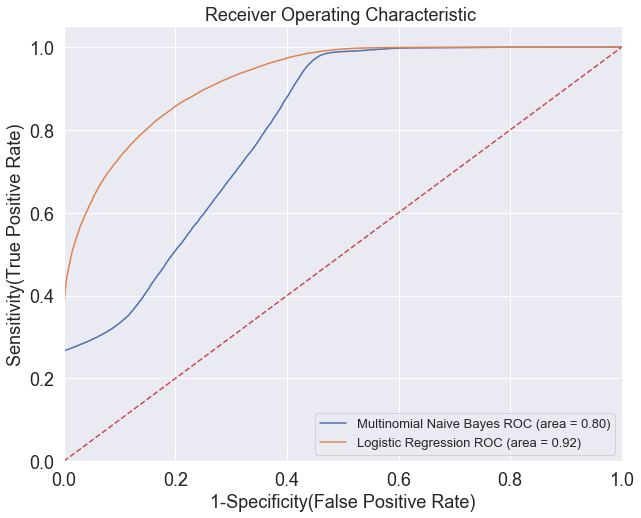

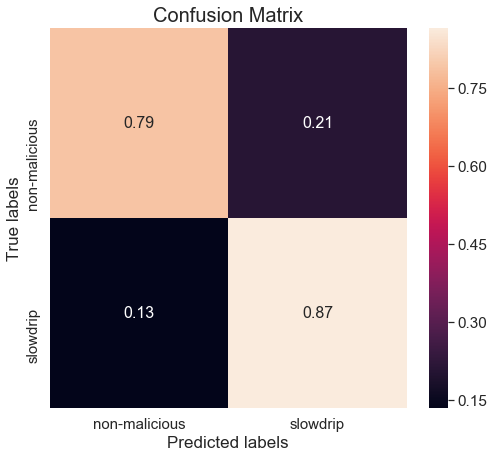

In [187]:
plt.figure(figsize=(10,8))
models = [

{
    'label': 'Multinomial Naive Bayes',
    'model': MultinomialNB(alpha= 0.001),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(solver= 'saga'),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(combined_train_X, label_train) # train the model
    y_pred=model.predict(combined_test_X) # predict the test data
    print("%.2f" %accuracy_score(label_test ,y_pred))
# Compute False postive rate, and True positive rate
    y_prob = model.predict_proba(combined_test_X)[:,1]
    fpr, tpr, thresholds = roc_curve(label_test, y_prob)
    
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(label_test, y_prob)
    print(auc)   

    cm = confusion_matrix(label_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize = 18)
plt.xlabel('1-Specificity(False Positive Rate)', fontsize = 18)
plt.ylabel('Sensitivity(True Positive Rate)',fontsize = 18)
plt.title('Receiver Operating Characteristic ',fontsize = 18)
plt.legend(loc="lower right",fontsize = 13)
plt.show()   # Display

plt.figure(figsize=(8,7))
sns.set(font_scale=1.4)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 16}); #annot=True to annotate cells

# labels, title and ticks
# sns.set_context(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
ax.set_xlabel('Predicted labels',fontsize = 17);ax.set_ylabel('True labels',fontsize=17); 
ax.set_title('Confusion Matrix',fontsize=20); 
ax.xaxis.set_ticklabels(['non-malicious', 'slowdrip'],fontsize = 15);
ax.yaxis.set_ticklabels(['non-malicious', 'slowdrip'],fontsize = 15);


# fig = ax.get_figure()
# fig.savefig("conf.png",dpi = 200)